# Task 4 Model Architecture + Training + Evaluation on Google Colab

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from torchsummary import summary
import os
import pickle
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
task_name = "task4"
EPOCHS = 9
lr = 0.0001
batch_size = 8
train_path = '/content/drive/MyDrive/DL_Assignment_Data/train/'
val_path = '/content/drive/MyDrive/DL_Assignment_Data/val/'
test_path = '/content/drive/MyDrive/DL_Assignment_Data/test/'

# GPU specific args
num_workers = 4
pin_memory = True

metrics_file_path = lambda metric: f"/content/drive/MyDrive/DL_Assignment_Data/checkpoints/{task_name}/{task_name}-{metric}.pkl"

checkpoint_dir = f'/content/drive/MyDrive/DL_Assignment_Data/checkpoints/{task_name}'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")

using cpu


In [6]:
if device == "cuda":
    torch.cuda.empty_cache()

# del model, optim, criterion, train, dataloader

In [4]:
class EncoderBlock(nn.Module):
    """Block applies 2 conv layers and 1 max pooling layer"""
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x_pool = self.pool(x)
        return x, x_pool

class BottleneckBlock(nn.Module):
    """Block applies 2 conv layers"""
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, bridge:torch.tensor):
        x = self.upconv(x)
        diffY = x.size()[2] - bridge.size()[2]
        diffX = x.size()[3] - bridge.size()[3]
        bridge = F.pad(
            bridge,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x, bridge], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    """Implementation of UNet model for classification task"""
    def __init__(self, in_channels, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([EncoderBlock(in_channels, features[0])])
        self.encoder.extend(
            [EncoderBlock(features[i], features[i+1]) for i in range(len(features)-1)])

        self.bottleneck = BottleneckBlock(features[-1], features[-1]*2)

        self.decoder = nn.ModuleList([DecoderBlock(features[-1]*2, features[-1])])
        # one decoder for every channel expansion
        self.decoder.extend(
            [DecoderBlock(features[i], features[i-1]) for i in range(-1, -len(features), -1)])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(features[0], 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bridges = []

        # Encoder
        for encoder in self.encoder:
            x, bridge = encoder(x)
            bridges.append(bridge)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, decoder in enumerate(self.decoder):
            bridge = bridges[-i-1]
            x = decoder(x, bridge)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = self.sigmoid(x)
        return x

#### Bring in the data

In [12]:
# Get data in

# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):
train = 'train'
val = 'val'
test = 'test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

input_shape = (img_width, img_height, 3)

# train set size
nb_train_samples = 20000
# validation set size
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500


resize = transforms.Resize(size=(img_height, img_width))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_data = ImageFolder(train_path, transform=trainTransforms)
val_data = ImageFolder(val_path, transform=valTransforms)
test_data = ImageFolder(test_path, transform=testTransforms)
# Setup the batch size hyperparameter
BATCH_SIZE = batch_size

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=pin_memory
)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=pin_memory
)

val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=pin_memory
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f4b1d1f3610>, <torch.utils.data.dataloader.DataLoader object at 0x7f4c0f6751e0>)
Length of train dataloader: 2513 batches of 8
Length of val dataloader: 312 batches of 8
Length of test dataloader: 313 batches of 8


In [7]:
def clear_memory():
    torch.cuda.empty_cache()
    del inputs, labels, outputs, preds

In [5]:
# Create a ResNet model
model = UNet(in_channels=3, features=[8, 16, 32, 64]).to(device)

summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 150, 150]             224
       BatchNorm2d-2          [-1, 8, 150, 150]              16
              ReLU-3          [-1, 8, 150, 150]               0
            Conv2d-4          [-1, 8, 150, 150]             584
       BatchNorm2d-5          [-1, 8, 150, 150]              16
              ReLU-6          [-1, 8, 150, 150]               0
         MaxPool2d-7            [-1, 8, 75, 75]               0
      EncoderBlock-8  [[-1, 8, 150, 150], [-1, 8, 75, 75]]               0
            Conv2d-9         [-1, 16, 150, 150]           1,168
      BatchNorm2d-10         [-1, 16, 150, 150]              32
             ReLU-11         [-1, 16, 150, 150]               0
           Conv2d-12         [-1, 16, 150, 150]           2,320
      BatchNorm2d-13         [-1, 16, 150, 150]              32
             ReLU-14        

In [ ]:

# training
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = lr)

epoch_losses = []
epoch_accuracys = []
epoch_val_accuracys = []
epoch_val_losses = []



losses_file_path = metrics_file_path("train-losses")
if os.path.exists(losses_file_path):
    with open(losses_file_path, 'rb') as f:
        epoch_losses = pickle.load(f)
    with open(metrics_file_path("train-accuracys"), 'rb') as f:
        epoch_accuracys = pickle.load(f)
    with open(metrics_file_path("val-accuracys"), 'rb') as f:
        epoch_val_accuracys = pickle.load(f)
    with open(metrics_file_path("val-losses"), 'rb') as f:
        epoch_val_losses = pickle.load(f)
    print("Performance metrics for last epoch loaded")
else:
    print("No file found for past performance metrics")


# set up path to save model
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

latest_checkpoint_number = max(
    [int(f[11:-3]) for f in os.listdir(checkpoint_dir) if f.startswith('model_epoch')],
    default=None
)

last_epoch = 0
if latest_checkpoint_number:
    latest_checkpoint = f"model_epoch{latest_checkpoint_number}.pt"
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint from epoch {last_epoch} with loss: {loss}")

scaler = GradScaler()

for epoch in range(last_epoch + 1, EPOCHS + 1):
    preds_list = []
    labels_list = []
    losses = []
    for i, data in enumerate(tqdm(train_dataloader), 0):
        inputs, labels = data
        # ACTIVATE ON GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs).squeeze()
            preds = ((outputs > 0) * 1.0)
            loss = criterion(outputs.float(), labels.squeeze().float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds_list += list(preds)
        labels_list += list(labels.data)
        losses.append(loss.item())
        torch.cuda.empty_cache()
        del inputs

    epoch_corrects = sum([1 for a, b in zip(preds_list, labels_list) if a==b])
    accuracy = epoch_corrects / len(labels_list)
    epoch_accuracys.append(accuracy)
    epoch_loss = sum(losses) / len(losses)
    epoch_losses.append(epoch_loss)

    # model evaluation
    model.eval()
    val_corrects = 0
    val_total = 0
    val_losses = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_dataloader), 0):
            inputs, labels = data
            # ACTIVATE ON GPU
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs).squeeze()
                preds = ((outputs > 0) * 1.0)
                loss = criterion(outputs.float(), labels.squeeze().float())

            val_corrects += torch.sum(preds == labels.data)
            val_total += len(preds)
            val_losses.append(loss)
            torch.cuda.empty_cache()
            del inputs

    epoch_val_accuracy = (val_corrects / val_total).item()
    epoch_val_accuracys.append(epoch_val_accuracy)
    epoch_val_loss = (sum(val_losses) / len(val_losses)).item()
    epoch_val_losses.append(epoch_val_loss)
    print(epoch_accuracys, epoch_losses, epoch_val_accuracys, epoch_val_losses)

    # Save model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Model saved after {epoch} epochs.")

    with open(metrics_file_path("train-losses"), 'wb') as f:
        pickle.dump(epoch_losses, f)
    with open(metrics_file_path("train-accuracys"), 'wb') as f:
        pickle.dump(epoch_accuracys, f)
    with open(metrics_file_path("val-accuracys"), 'wb') as f:
        pickle.dump(epoch_val_accuracys, f)
    with open(metrics_file_path("val-losses"), 'wb') as f:
        pickle.dump(epoch_val_losses, f)
    print("Performace metrics saved")


Performance metrics for last epoch loaded
Loaded checkpoint from epoch 8 with loss: 0.9423079490661621


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


[0.6062686567164179, 0.6687562189054727, 0.6546766169154229, 0.6949751243781095, 0.7172636815920398, 0.7355721393034826, 0.7658208955223881, 0.7816417910447762, 0.7842786069651742] [0.6469595874394737, 0.6058982264649284, 0.6172384550810525, 0.5780307965370179, 0.5560467533983655, 0.5341204300054363, 0.49150145359832453, 0.4772410538452249, 0.46725908757276] [0.5740000009536743, 0.7103999853134155, 0.7111999988555908, 0.7343999743461609, 0.7639999985694885, 0.769599974155426, 0.7892000079154968, 0.8163999915122986, 0.8208000063896179] [0.7143598198890686, 0.5649978518486023, 0.5641980767250061, 0.5323333740234375, 0.5092950463294983, 0.49641406536102295, 0.4667156934738159, 0.4459451138973236, 0.42893195152282715]
Model saved after 9 epochs.
Performace metrics saved


## Model evaluation on test set

In [9]:
def get_latest_checkpoint_number(task_name:str) -> int:
    checkpoint_dir = f'/content/drive/MyDrive/DL_Assignment_Data/checkpoints/{task_name}'
    latest_checkpoint_number = max(
        [int(f[11:-3]) for f in os.listdir(checkpoint_dir) if f.startswith('model_epoch')],
        default=None
    )
    return latest_checkpoint_number

def get_checkpoint_by_model_number(
        task_name:str,
        model_number:int):
    checkpoint_dir = f'/content/drive/MyDrive/DL_Assignment_Data/checkpoints/{task_name}/'
    checkpoint_name = f"model_epoch{model_number}.pt"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        print(f"Checkpoint {model_number} loaded")
        return checkpoint
    return None

In [9]:
task_name = "task4"
# data_path = "data/test/"
data_path = f"/content/drive/MyDrive/DL_Assignment_Data/test"

epochs = get_latest_checkpoint_number(task_name)

criterion = nn.BCEWithLogitsLoss()

epoch_test_accuracys = []
epoch_test_losses = []

for i in range(epochs):
    model = UNet(in_channels=3, features=[8, 16, 32, 64]).to(device)
    checkpoint = get_checkpoint_by_model_number(task_name, i+1)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    test_corrects = 0
    test_total = 0
    test_losses = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_dataloader), 0):
            inputs, labels = data
            # ACTIVATE ON GPU
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs).squeeze()
                preds = ((outputs > 0) * 1.0)
                loss = criterion(outputs.float(), labels.squeeze().float())

            test_corrects += torch.sum(preds == labels.data)
            test_total += len(preds)
            test_losses.append(loss)
            torch.cuda.empty_cache()
            del inputs

    epoch_test_accuracy = (test_corrects / test_total).item()
    epoch_test_accuracys.append(epoch_test_accuracy)
    epoch_test_loss = (sum(test_losses) / len(test_losses)).item()
    epoch_test_losses.append(epoch_test_loss)

Checkpoint 1 loaded


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Checkpoint 2 loaded


100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Checkpoint 3 loaded


100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Checkpoint 4 loaded


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Checkpoint 5 loaded


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Checkpoint 6 loaded


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Checkpoint 7 loaded


100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Checkpoint 8 loaded


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Checkpoint 9 loaded


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


In [10]:
with open(metrics_file_path("test-losses"), 'wb') as f:
    pickle.dump(epoch_test_losses, f)
with open(metrics_file_path("test-accuracys"), 'wb') as f:
    pickle.dump(epoch_test_accuracys, f)

## Plotting Epoch vs Accuracy and Epoch vs Loss

In [7]:
# Plot Epoch vs Accuracy and Epoch vs Loss
with open(metrics_file_path("train-losses"), 'rb') as f:
    epoch_losses = pickle.load(f)
with open(metrics_file_path("train-accuracys"), 'rb') as f:
    epoch_accuracys = pickle.load(f)
with open(metrics_file_path("val-accuracys"), 'rb') as f:
    epoch_val_accuracys = pickle.load(f)
with open(metrics_file_path("val-losses"), 'rb') as f:
    epoch_val_losses = pickle.load(f)
with open(metrics_file_path("test-accuracys"), 'rb') as f:
    epoch_test_accuracys = pickle.load(f)
with open(metrics_file_path("test-losses"), 'rb') as f:
    epoch_test_losses = pickle.load(f)

In [10]:
def create_plots(
        train_accuracy_list:list,
        train_loss_list:list,
        val_accuracy_list:list,
        val_loss_list:list,
        task_name:str,
        epoch_list:list
          ) -> None:
    """Function to create accuracy and loss plots over epochs"""

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
    plt.plot(epoch_list, val_accuracy_list, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Train Accuracy')
    plt.legend()
    plt.grid(linewidth=0.5)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_loss_list, label='Train Loss')
    plt.plot(epoch_list, val_loss_list, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Train Loss')
    plt.legend()
    plt.grid(linewidth=0.5)
    plt.tight_layout()

    # Save the plots
    plt.savefig(f'/content/drive/MyDrive/DL_Assignment_Data/task4')

    plt.show()


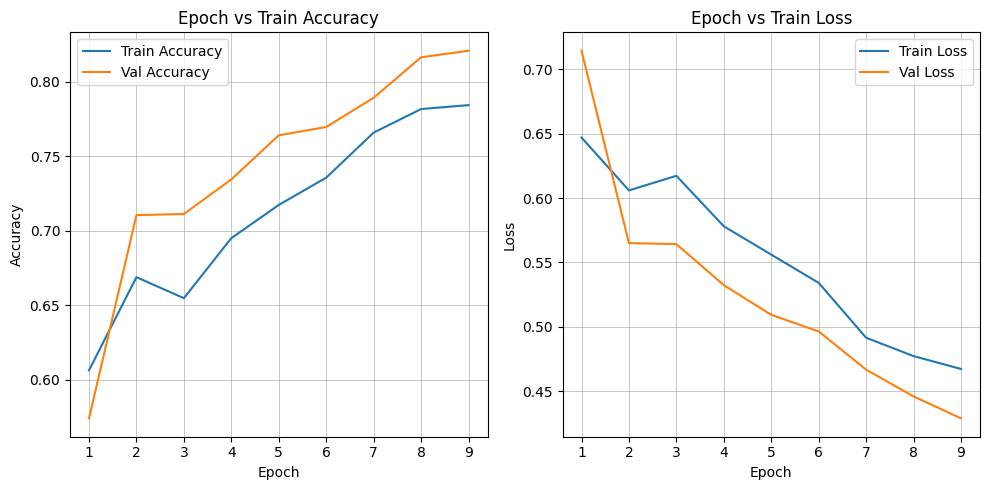

In [11]:
create_plots(
    train_accuracy_list=epoch_accuracys,
    train_loss_list=epoch_losses,
    val_accuracy_list=epoch_val_accuracys,
    val_loss_list=epoch_val_losses,
    task_name=f"{task_name}",
    epoch_list=list(range(1, len(epoch_accuracys)+1))
)

## Checking the Test Accuracy

In [13]:
test_accuracy = epoch_test_accuracys[-1]
test_loss = epoch_test_losses[-1]
print(f"Test Accuracy: {test_accuracy * 100:.3f}% \nTest Loss: {test_loss:.3f}")

Test Accuracy: 82.080% 
Test Loss: 0.429


## Finding misclassified examples

In [14]:
# check model accuracy
best_model_number = 9

model = UNet(in_channels=3, features=[8, 16, 32, 64]).to(device)

best_checkpoint = get_checkpoint_by_model_number(
    task_name=task_name,
    model_number=best_model_number)

model.load_state_dict(best_checkpoint['model_state_dict'])

# test_accuracy, test_loss = get_model_score(
#     model=model,
#     dataloader=test_dataloader,
#     criterion=criterion)

# print(f"Test Accuracy: {test_accuracy * 100:.3f}% \nTest Loss: {test_loss:.3f}")

Checkpoint 9 loaded


<All keys matched successfully>

In [16]:
# finding misclassified images
incorrect_examples = []
correct_cat_examples = []
correct_dog_examples = []

with torch.no_grad():
    for i, data in enumerate(tqdm(test_dataloader), 0):
        inputs, labels = data
        # ACTIVATE ON GPU
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
            outputs = model(inputs).squeeze()
            preds = ((outputs > 0) * 1.0)



model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
            outputs = model(inputs).squeeze()
            preds = ((outputs > 0) * 1.0)
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred == label:
                if label.item() == 0:
                    correct_cat_examples.append(inputs[i])
                elif label.item() ==  1:
                    correct_dog_examples.append(inputs[i])
            else:
                if outputs[i] > 0.75:
                    incorrect_examples.append(inputs[i])
        if min(len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)) >= 1:
            break

  0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 50%|████▉     | 156/313 [00:20<00:20,  7.56it/s]


In [22]:
incorrect = incorrect_examples[0].permute(1, 2, 0).to("cpu")
cat = correct_cat_examples[0].permute(1, 2, 0).to("cpu")
dog = correct_dog_examples[0].permute(1, 2, 0).to("cpu")

len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)

(59, 1127, 6)

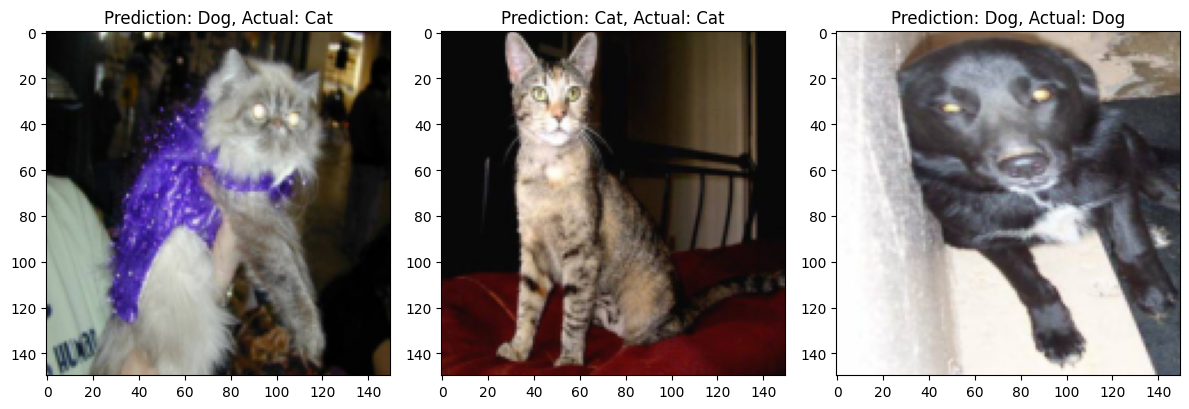

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display img1 on the first subplot
axs[0].imshow(incorrect, cmap='gray')
axs[0].set_title('Prediction: Dog, Actual: Cat')

# Display img2 on the second subplot
axs[1].imshow(cat, cmap='gray')
axs[1].set_title('Prediction: Cat, Actual: Cat')

# Display img3 on the third subplot
axs[2].imshow(dog, cmap='gray')
axs[2].set_title('Prediction: Dog, Actual: Dog')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(f"/content/drive/MyDrive/DL_Assignment_Data/task4")

# Display the plots
plt.show()

Learning Rates

In [1]:
# 1-6 : 0.001
# 7-9 : 0.0001